# Pearson's correlation coefficient

<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../notebooks/08_colocalization/pixel_intensity_based_colocalization_pearsons.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/08_colocalization/pixel_intensity_based_colocalization_pearsons.ipynb" target="_blank">
        <img class="button-icon" src="../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "numpy",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
#     "coloc_tools @ git+https://github.com/fdrgsp/coloc_tools.git"
# ]
# ///

## Description

In this section, we will explore how to implement in Python the **Pearson's Correlation Coefficient**, which is a common method for quantifying colocalization based on pixel intensities.

The images we will use for this section can be downloaded from the <a href="../../_static/data/08_pixel_intensity_based_coloc.zip" download> <i class="fas fa-download"></i> Mander's & Pearson's Colocalization Dataset</a>.

<p class="alert alert-warning">
    <strong>Note:</strong> This notebook aims to show how to practically implement these methods but does not aim to describe when to use which method. For this exercise, we will use a single 2-channel image and without any preprocessing steps.
</p>

<p class="alert alert-info">
    <strong>Note:</strong> In this example, we will not perform any image processing steps before computing the Pearson's Correlation Coefficient. However, when conducting a real colocalization analysis you should consider applying some image processing steps to clean the images before computing the Pearson's Correlation Coefficient, such as background subtraction, flat-field correction, etc.
</p>

<p class="alert alert-info">
    <strong>Note:</strong> In this notebook we will only use a single image pair for demonstration purposes. Often, Pearson's coefficients should not be interpreted as absolute values in isolation. Instead, it's always recommended to consider them in the context of comparisons between different conditions, controls, treatments, or experimental groups. The relative changes and ratios between conditions are often more meaningful than the absolute coefficient values themselves.
</p>

## Pearson's Correlation Coefficients

The Pearson's correlation coefficient measures the **linear relationship** between pixel intensities in two fluorescence channels. 

<div align="center"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/pearsons_slide.png" alt="pearsons" width="800"></div>

<br>

It quantifies how well the intensity variations in one channel predict the intensity variations in another channel across all pixels in the image. 

The coefficient ranges from **-1 to +1**, where:
- **+1** indicates perfect positive correlation (when one channel's intensity increases, the other increases proportionally)
- **0** indicates no linear correlation
- **-1** indicates perfect negative correlation (when one channel's intensity increases, the other decreases proportionally)

<div align="center"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/pearsons_graphs.png" alt="pearsons_graphs" width="770"></div>

<br>

Pearson's correlation considers the **entire intensity range** and evaluates how intensities **co-vary** across the image. This makes it particularly useful for detecting cases where two proteins show coordinated expression levels, even if they don't necessarily occupy the exact same pixels.

### import libraries

In [ ]:
import matplotlib.pyplot as plt
import ndv
import numpy as np
import tifffile
from coloc_tools import costes_pixel_randomization
from scipy.stats import pearsonr

### Load and Visualize the Image

Open and visualize (with ndv) the image named `cells_pearsons.tif` from the <a href="../../_static/data/08_pixel_intensity_based_coloc.zip" download><i class="fas fa-download"></i> Mander's & Pearson's Colocalization Dataset</a>. This is a two-channel image of HEK293 cells where two distinct fluorescent proteins have been labeled with different fluorescent markers.

In [ ]:
# open the image
img_path = "../../_static/images/coloc/t_cell.tif"
img = tifffile.imread(img_path)

In [ ]:
# visualize the image
ndv.imshow(img)

In [ ]:
viewer = ndv.imshow(img)

In [ ]:
viewer.widget().children[1].snapshot()

To compute Pearson's Correlation Coefficients, we need **two separate images** (channels).

What is the image shape? How do we split the channels?

In [ ]:
# get image shape
print("Image shape:", img.shape)

In [6]:
# split the image into channels
ch1 = img[0]
ch2 = img[1]

### Scatter Plot

It is often useful to visualize the relationship between the two channels using a scatter plot. This can help us understand the distribution of pixel intensities.

In [ ]:
# plot scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(ch1.ravel(), ch2.ravel(), s=3, alpha=0.5)
plt.xlabel("Channel 1 Intensity")
plt.ylabel("Channel 2 Intensity")
plt.title("Scatter Plot of Pixel Intensities")
# set both axes to the same range based on the maximum value
max_intensity = max(ch1.max(), ch2.max()) + 100
plt.xlim(0, max_intensity)
plt.ylim(0, max_intensity)
plt.show()

### Calculate Pearson's Correlation Coefficients

In [ ]:
mean_ch1 = np.mean(ch1)
mean_ch2 = np.mean(ch2)

numerator = np.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
denominator = np.sqrt(np.sum((ch1 - mean_ch1) ** 2) * np.sum((ch2 - mean_ch2) ** 2))
prs = numerator / denominator
print(f"Pearson's: {prs:.2}")

There are several libraries in Python that alreqady implement the Pearson's Correlation Coefficient. Two examples are `scipy.stats.pearsonr` and `numpy.corrcoef`.

In [ ]:
# Calculate Pearson's correlation coefficient using scipy
pearson, p_value = pearsonr(ch1.ravel(), ch2.ravel())
print(f"Pearson's (scipy): {pearson:.2f}, p-value: {p_value:.4f}")
# Calculate Pearson's correlation coefficient using numpy
pearson_numpy = np.corrcoef(ch1.ravel(), ch2.ravel())[0, 1]
print(f"Pearson's (numpy): {pearson_numpy:.2f}")

### Costes Pixel Randomization Test

The **Costes pixel randomization test** is a statistical method used to validate the significance of colocalization results, particularly for Pearson's correlation coefficients. This method involves **randomly shuffling the pixel intensities of one channel and recalculating the Pearson's correlation coefficient** to create a distribution of values under the null hypothesis of no colocalization.

[Here](https://github.com/fdrgsp/coloc_tools/blob/a1e07ff9e5bed5ed4fa166ae1ac416ebf3bbc58c/src/coloc_tools/_costes_pixel_randomization.py#L5) you can find an implementation of this method in Python. This function returns the observed Pearson's correlation coefficient, a list of randomized correlation coefficients, and the p-value indicating the significance of the observed correlation.

A low `p-value` (e.g. 0.0001) means that none of the `n` random translations (by default 500) produced a correlation coefficient as high as the observed one, indicating that the observed colocalization is statistically significant: the probability of getting the observed colocalization by random chance is < 0.0001 (less than 0.01%).

Let's run it on the two channels we have been working with.

We can now run the Costes pixel randomization test and print the pearson's correlation coefficient, the p-value and the first 5 randomized correlation coefficients.

In [ ]:
pearson, random_corrs, p_value = costes_pixel_randomization(ch1, ch2, n_iterations=100)
print(f"Observed Pearson's correlation: {pearson:.2f}, p-value: {p_value:.4f}\n")
# first 5 random correlations
print(random_corrs[:5])

Observed Pearson's correlation: 0.84, p-value: 0.0000

[
    np.float64(0.0011972008980566714),
    np.float64(0.002486536645632801),
    np.float64(0.0025632801275921524),
    np.float64(-0.002494077988106206),
    np.float64(0.002210413581187374)
]

**Bonus:** We can also visualize the distribution of the randomized Pearson's correlation coefficients to better understand the significance of our observed correlation.

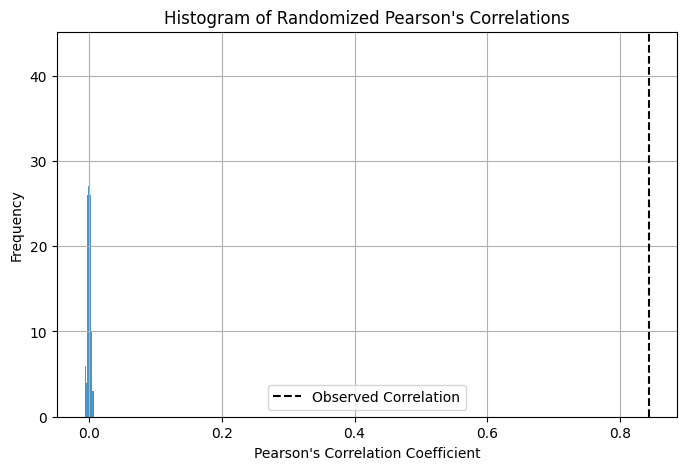

In [11]:
# plot histogram of random correlations
plt.figure(figsize=(8, 5))
plt.hist(random_corrs, bins=30, alpha=0.8)
plt.axvline(
    pearson, color="k", linestyle="dashed", linewidth=1.5, label="Observed Correlation"
)
plt.title("Histogram of Randomized Pearson's Correlations")
plt.xlabel("Pearson's Correlation Coefficient")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

### Summary

The Python implementation for calculating Pearson's Correlation Coefficient is straightforward and concise, as demonstrated in the code below.

```python
mean_ch1 = np.mean(ch1)
mean_ch2 = np.mean(ch2)
numerator = np.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
denominator = np.sqrt(np.sum((ch1 - mean_ch1) ** 2) * np.sum((ch2 - mean_ch2) ** 2))
pearson_coefficient = numerator / denominator
```

And it is even easier using already available libraries like `scipy` or `numpy`:

```python
from scipy.stats import pearsonr
pearson_coefficient, p_value = pearsonr(ch1.ravel(), ch2.ravel())
```
```python
import numpy as np
pearson_coefficient = np.corrcoef(ch1.ravel(), ch2.ravel())[0, 1]
```

**Important Note on Spatial Information:**

It's crucial to understand that **Pearson's correlation works on vectors/pairs of values and does not use spatial information at all**. The correlation is calculated based purely on the intensity values and their relationships, regardless of where those pixels are located in the image. This means that if you randomly shuffle the pixel positions in both channels in exactly the same way, you would get identical Pearson's correlation results. This characteristic makes Pearson's correlation fundamentally different from spatial colocalization measures and emphasizes that it's measuring intensity co-variation rather than spatial co-occurrence.

**Key Considerations for Pearson's Correlation Analysis:**

1. **Region of Interest (ROI) Analysis**: Instead of running Pearson's correlation on the entire image, it is often beneficial to perform **segmentation of the structures you care about** first. Ideally, use a **third independent channel** (such as a nuclear stain or cell membrane marker) to define regions of interest. This approach:
   - Reduces background noise interference
   - Focuses analysis on biologically relevant areas
   - Improves the biological interpretation of results
   - Eliminates correlation artifacts from empty regions

2. **Background Considerations**: Pearson's correlation can be heavily influenced by background pixels. Consider applying background subtraction or flat-field correction before analysis, or use segmentation masks to exclude background regions.

3. **Statistical Validation**: Always validate your results using statistical tests such as the Costes pixel randomization test demonstrated above. This helps assess whether observed correlations are statistically significant or could have occurred by chance. Rotating 90 or 180 degrees one channel and computing Pearson's correlation can also help validate the significance of the observed correlation.

   - **Costes Test**: This test generates a distribution of Pearson's coefficients from randomized pixel intensities, allowing you to calculate a p-value for your observed correlation. A low p-value indicates that the observed correlation is unlikely to have occurred by chance.

4. **Comparative Analysis**: Pearson's correlation values should not be interpreted as absolute measures in isolation. Instead, consider them in the context of:
   - Comparisons between different experimental conditions
   - Control vs. treatment groups
   - Different time points or developmental stages
   - Relative changes between conditions are often more meaningful than absolute values

5. **Limitations**: Remember that Pearson's correlation measures **linear relationships** between pixel intensities. It may not capture more complex colocalization patterns and can be sensitive to outliers and intensity variations.

By combining proper image preprocessing, ROI-based analysis, and statistical validation, Pearson's correlation coefficient becomes a powerful tool for quantitative colocalization analysis in fluorescence microscopy.